In [6]:
library(rhdf5)
library(MASS)
library(broom)

# Test reading h5 and accessing data

In [7]:
fh <- "../simulated_data/sim.h5"

Get internal structure of h5 file

In [8]:
h5ls(fh)

ERROR: Error in H5Fopen(file, flags = flags, fapl = fapl, native = native): HDF5. File accessibility. Unable to open file.


Test reading first row from counts matrix

In [9]:
system.time(row.counts <- h5read(file = fh, name = "counts", index = list(1, 1:50000)))

ERROR: Error in h5checktypeOrOpenLoc(file, readonly = TRUE, fapl = NULL, native = native): Error in h5checktypeOrOpenLoc(). Cannot open file. File '../simulated_data/sim.h5' does not exist.


Timing stopped at: 0.004 0 0.004



In [108]:
row.counts

0,15,4,2,1,0,0,44,30,20,⋯,6,8,16,1,24,0,0,0,0,4


Check if this matches

In [109]:
counts.mtx <- h5read(fh, "counts")
dim(counts.mtx)
counts.mtx[1,1:10]

[1] 13000 50000

[1]  0 15  4  2  1  0  0 44 30 20

Try pulling a row from matrix of $X_1$

In [110]:
system.time(row.vars <- h5read(file = fh, name = "x/x1", index = list(1, 1:50000)))

   user  system elapsed 
  0.534   0.006   0.541 

In [111]:
sum(row.vars)

[1] 309

Check if this is correct

In [112]:
x1.mtx <- h5read(fh, "x/x1")
sum(x1.mtx[1,1:50000])

[1] 309

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [113]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")

In [114]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,8890,0.5839696,-3.091298
2,8344,0.6177571,-2.482861
3,10894,0.7364427,-2.701824
4,5123,0.7752164,-2.813812
5,6571,0.7739046,-2.201368
6,3693,0.5629113,-1.948516


In [115]:
2 %in% guides.metadata$target.gene

[1] FALSE

# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene with `glm.nb` (MASS library)

In [116]:
test.gene <- 1

obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

In [117]:
head(gene.data)

,guide.eff,s.score,g2m.score,counts,scaling.factor
,<int>,<dbl>,<dbl>,<int>,<dbl>
1,0,-0.6605419,-0.31670538,0,0.050167
2,0,1.3238916,-1.14640695,15,0.050184
3,0,-0.1031474,0.29847610,4,0.050145
4,0,-0.3260718,0.60811720,2,0.049669
5,0,0.5385560,-0.86269276,1,0.050237
6,0,-0.3940143,-0.02239488,0,0.050092


In [118]:
system.time(ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), data = gene.data))

   user  system elapsed 
 23.862  21.565   2.403 

In [119]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), 
    data = gene.data, init.theta = 1.488063159, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0998  -0.8991  -0.3799   0.3111   3.4680  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.941475   0.005934   664.2   <2e-16 ***
guide.eff   -2.633693   0.089584   -29.4   <2e-16 ***
s.score      3.592102   0.010013   358.7   <2e-16 ***
g2m.score    1.937589   0.008672   223.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4881) family taken to be 1)

    Null deviance: 360995  on 49999  degrees of freedom
Residual deviance:  47562  on 49996  degrees of freedom
AIC: 241947

Number of Fisher Scoring iterations: 1


              Theta:  1.4881 
          Std. Err.:  0.0141 

 2 x log-likelihood:  -241936.9660 

In [120]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.939874,-2.46796,3.600448,1.945159


In [121]:
system.time(ml.null <- update(ml, . ~ . - guide.eff))

   user  system elapsed 
 21.542  18.498   2.279 

In [122]:
summary(ml.null)


Call:
glm.nb(formula = counts ~ s.score + g2m.score + offset(log(scaling.factor)), 
    data = gene.data, init.theta = 1.452913514, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0515  -0.9005  -0.3806   0.3115   3.4647  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 3.936000   0.005964   660.0   <2e-16 ***
s.score     3.590483   0.010081   356.1   <2e-16 ***
g2m.score   1.937013   0.008739   221.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4529) family taken to be 1)

    Null deviance: 353957  on 49999  degrees of freedom
Residual deviance:  47645  on 49997  degrees of freedom
AIC: 242682

Number of Fisher Scoring iterations: 1


              Theta:  1.4529 
          Std. Err.:  0.0137 

 2 x log-likelihood:  -242673.7450 

In [123]:
anova(ml, ml.null)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
s.score + g2m.score + offset(log(scaling.factor)),1.452914,49997,-242673.7,,NA,NA,NA
guide.eff + s.score + g2m.score + offset(log(scaling.factor)),1.488063,49996,-241937.0,1 vs 2,1,736.7782,0


### Test with R `optim()`

In [80]:
fit_alt <- function(par, counts, x1, x2, x3, scale){
    # par[1:4] = beta0, beta1 (enhancer effect), beta2 (S score), beta3 (G2M score)
    # par[5] = sqrt(disp)
    # counts = observed counts for gene
    # x1 = indicator variable for whether gRNA(s) targeting enhancer have effect 
    # x2 = S cycle scores
    # x3 = G2M cycle scores 
    # scale = scaling factor
    beta0 <- par[1]
    beta1 <- par[2]
    beta2 <- par[3]
    beta3 <- par[4]
    d <- par[5]^2
    mu <- scale*exp(beta0 + beta1*x1 + beta2*x2 + beta3*x3)
    print(mu)
    -sum(dnbinom(counts, mu = mu, size = d, log = T))
}

fit_null <- function(par, counts, x2, x3, scale){
    # par[1:3] = beta0, beta2 (S score), beta3 (G2M score)
    # par[4] = sqrt(disp)
    # counts = observed counts for gene
    # x2 = S cycle scores
    # x3 = G2M cycle scores 
    # scale = scaling factor
    beta0 <- par[1]
    beta2 <- par[2]
    beta3 <- par[3]
    d <- par[4]^2
    mu <- scale*exp(beta0 + beta2*x2 + beta3*x3)
    print(mu)
    -sum(dnbinom(counts, mu = mu, size = d, log = T))
}

In [93]:
system.time(optim.alt <- optim(c(1,1,1,1,1), fit_alt, 
                   counts = obs.counts, 
                   x1 = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                   x2 = cell.cycle.scores$s.scores,
                   x3 = cell.cycle.scores$g2m.scores,
                   scale = scaling.factors, method= 'L-BFGS-B'))
print(optim.alt)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Timing stopped at: 1483 34.08 1517



# Test for all target genes

E.g. the 2000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [68]:
ml.list <- list()
ml.null.list <- list()

system.time(
# for (gene in 1:nrow(coeffs)) {
for (gene in guides.metadata$target.gene) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       lnscaling.factor = log(scaling.factors))
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + ln.scaling.factor, data = gene.data)
    ml.null <- update(ml, . ~ . - guide.eff)
    ml.list[[gene]] <- ml
    ml.null.list[[gene]] <- ml.null
}
)



[1] 8890
[1] 8344
[1] 10894
[1] 5123
[1] 6571
[1] 3693
[1] 9289
[1] 9798
[1] 4602
[1] 12946
[1] 860
[1] 6055
[1] 5559
[1] 3631
[1] 11016
[1] 2967
[1] 2118
[1] 5690
[1] 10439
[1] 8903
[1] 9733
[1] 8399
[1] 10228
[1] 1950
[1] 6633
[1] 4678
[1] 62
[1] 9081
[1] 6789
[1] 4822
[1] 8569
[1] 3875
[1] 12448
[1] 7436
[1] 6305
[1] 9023
[1] 11591
[1] 8152
[1] 3882
[1] 2007
[1] 12907
[1] 6712
[1] 5013
[1] 12736
[1] 11981
[1] 7507
[1] 2910
[1] 10554
[1] 1858
[1] 4281
[1] 4769
[1] 255
[1] 10879
[1] 12215


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced

Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in glm.nb(formula = counts ~ s.score + g2m.score + scaling.factor, :
“alternation limit reached”


[1] 5895
[1] 7950
[1] 10932
[1] 1493
[1] 6001
[1] 12625
[1] 5484
[1] 5110
[1] 7731
[1] 1527
[1] 10266
[1] 12191
[1] 693
[1] 1558
[1] 4390
[1] 12761
[1] 1804
[1] 9139
[1] 4851
[1] 4693
[1] 5134
[1] 4042
[1] 6403
[1] 12002
[1] 7919
[1] 6126
[1] 2898
[1] 7581
[1] 8348
[1] 5178
[1] 4708
[1] 1184
[1] 607
[1] 5564
[1] 7283
[1] 2407
[1] 11901
[1] 1159
[1] 8937
[1] 9557
[1] 3671
[1] 306


Warning message:
“step size truncated due to divergence”


ERROR: Error: inner loop 1; cannot correct step size


Timing stopped at: 4239 3431 780.5



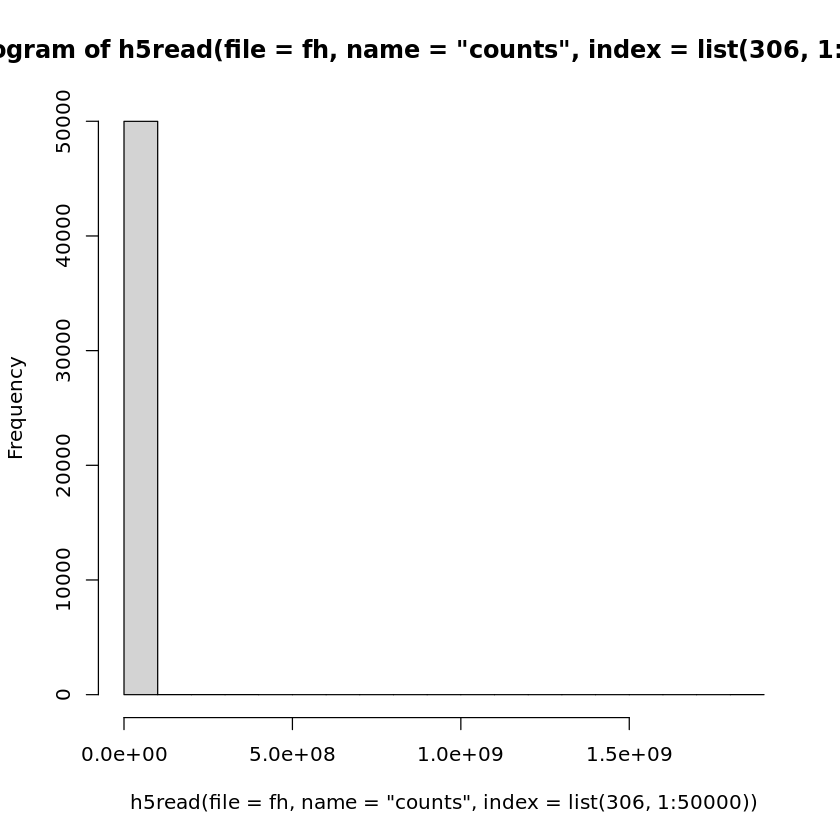

In [69]:
hist(h5read(file = fh, name = "counts", index = list(306, 1:50000)))

In [70]:
sum(h5read(file = fh, name = "counts", index = list(306, 1:50000)))

[1] 4377173532

In [72]:
h5read(file = fh, name = "counts", index = list(306, 1:50000))

0,0,0,19,0,0,0,8,0,0,⋯,0,1,1,2,0,1823,6,0,0,199628
